## Explicación:
En este notebook se lleva a cabo el análisis de un dataset complementario que muestra el comportamiento de los países en cuanto a su producción y demanda de energías renovables y no renovables. Lo cual ilustra la tendencia y la transicion (cada vez mas marcada) hacia un modelo sostenible de vida.

### ETL

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')


Importamos el dataset

In [149]:
df = pd.read_csv(r"C:\Users\Cristian\Desktop\DATA SCIENCE\HENRY\P_Final\Datasets complementarios\02 modern-renewable-energy-consumption.csv")

Lo visualizamos superficialmente para obtener una exploración inicial de los datos.

In [150]:
df.head(5)

,Entity,Code,Year,Geo Biomass Other - TWh,Solar Generation - TWh,Wind Generation - TWh,Hydro Generation - TWh
0,Africa,NaN,1971,0.164,0.0,0.0,26.013390
1,Africa,NaN,1972,0.165,0.0,0.0,29.633196
2,Africa,NaN,1973,0.170,0.0,0.0,31.345707
3,Africa,NaN,1974,0.175,0.0,0.0,35.667076
4,Africa,NaN,1975,0.172,0.0,0.0,37.717968


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5610 entries, 0 to 5609
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Entity                   5610 non-null   object 
 1   Code                     4299 non-null   object 
 2   Year                     5610 non-null   int64  
 3   Geo Biomass Other - TWh  5466 non-null   float64
 4   Solar Generation - TWh   5442 non-null   float64
 5   Wind Generation - TWh    5445 non-null   float64
 6   Hydro Generation - TWh   5603 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 306.9+ KB


Chequeamos datos nulos. Se puede observar la inexistencia de datos nulos.

In [152]:
df.isnull().sum()

Entity                        0
Code                       1311
Year                          0
Geo Biomass Other - TWh     144
Solar Generation - TWh      168
Wind Generation - TWh       165
Hydro Generation - TWh        7
dtype: int64

Se procederá a examinar el porcentaje de nulos por cada variable. Esto, con el objetivo de identificar la estrategia a seguir.

In [153]:
porcentaje_nulos = {}

for column in df.columns:
    porcentaje = round(df[column].isnull().sum() / df.shape[0]*100,2)
    porcentaje_nulos[column] = porcentaje
print(porcentaje_nulos)

{'Entity': 0.0, 'Code': 23.37, 'Year': 0.0, 'Geo Biomass Other - TWh': 2.57, 'Solar Generation - TWh': 2.99, 'Wind Generation - TWh': 2.94, 'Hydro Generation - TWh': 0.12}


Se puede observar que la mayoria de las variables con valores nulos presentan una porcentaje de nulos baja. Lo cual infiere una minima incidencia en caso de la eliminacion de estos datos nulos. Sin embargo, se observa la variable "Code" con la mayor cantidad de NaN. Se analizará la columna para identificar la metodologia a seguir.

In [154]:
df["Code"].value_counts()

Code
DZA         57
PAK         57
ROU         57
QAT         57
PRT         57
            ..
KAZ         37
HRV         32
SVN         32
MKD         32
OWID_USS    20
Name: count, Length: 81, dtype: int64

Se procedera a eliminar esta columna ya que tiene la misma informacion que el nombre.

In [155]:
df.drop(columns=["Code"], inplace = True)

In [156]:
df.dropna(inplace = True)

Se verifica el dataset de nuevo.

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5426 entries, 0 to 5609
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Entity                   5426 non-null   object 
 1   Year                     5426 non-null   int64  
 2   Geo Biomass Other - TWh  5426 non-null   float64
 3   Solar Generation - TWh   5426 non-null   float64
 4   Wind Generation - TWh    5426 non-null   float64
 5   Hydro Generation - TWh   5426 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 296.7+ KB


Se crea una nueva variable para contener el valor del total de Energia Renovable.

In [158]:
df['Total Renewable Energy Generation - TWh'] = df['Solar Generation - TWh'] + df['Wind Generation - TWh'] + df['Hydro Generation - TWh'] + df['Geo Biomass Other - TWh']

## EDA 
### Se procederá a hacer un Análisis Exploratio de los Datos desde una perspectiva estadistica.

In [159]:
df.describe()

,Year,Geo Biomass Other - TWh,Solar Generation - TWh,Wind Generation - TWh,Hydro Generation - TWh,Total Renewable Energy Generation - TWh
count,5426.000000,5426.000000,5426.000000,5426.000000,5426.000000,5426.000000
mean,1994.393660,13.518835,5.495616,15.080463,150.307824,184.402738
std,16.130671,47.810374,39.952908,84.871266,395.816898,524.543524
min,1965.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1981.000000,0.000000,0.000000,0.000000,1.300025,1.813175
50%,1995.000000,0.226500,0.000000,0.000000,10.580899,13.365863
75%,2008.000000,4.240750,0.017000,0.281110,63.735750,76.350806
max,2021.000000,762.782650,1032.501200,1861.939800,4345.990000,7931.051250


Se procederá a hacer un grafico de lineas con el objetivo de ver el comportamiento del Total de cada tipo de energía renovable en los ultimos 10 años. Se tomarán en cuenta los 5 países con mayor consumo de energia renovable.

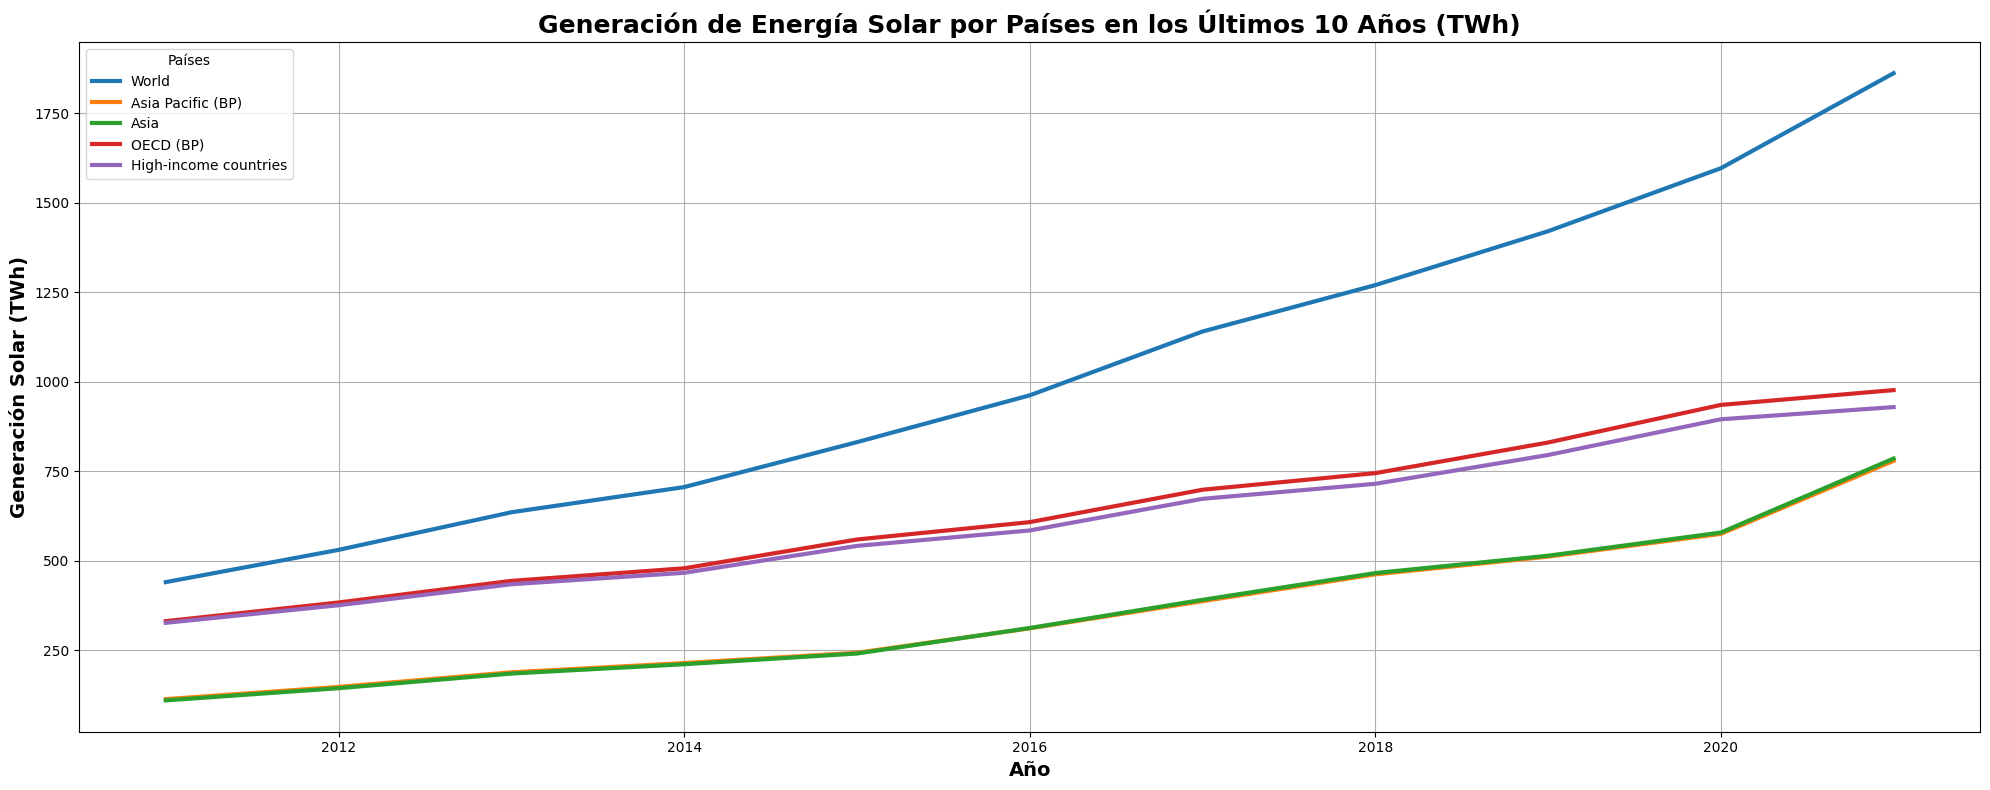

In [160]:
last_10_years_start = 2021 - 10
top_solar_countries = df[df['Year'] == 2021].nlargest(5, 'Solar Generation - TWh')

plt.figure(figsize=(20, 8))

for country in top_solar_countries['Entity']:
    country_data = df[(df['Entity'] == country) & (df['Year'] >= last_10_years_start)]
    plt.plot(country_data['Year'], country_data['Wind Generation - TWh'], linewidth=3, label=country)

plt.title('Generación de Energía Solar por Países en los Últimos 10 Años (TWh)', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14, fontweight='bold')
plt.ylabel('Generación Solar (TWh)', fontsize=14, fontweight='bold')
plt.legend(title='Países')
plt.grid(True)
plt.tight_layout()
plt.show()

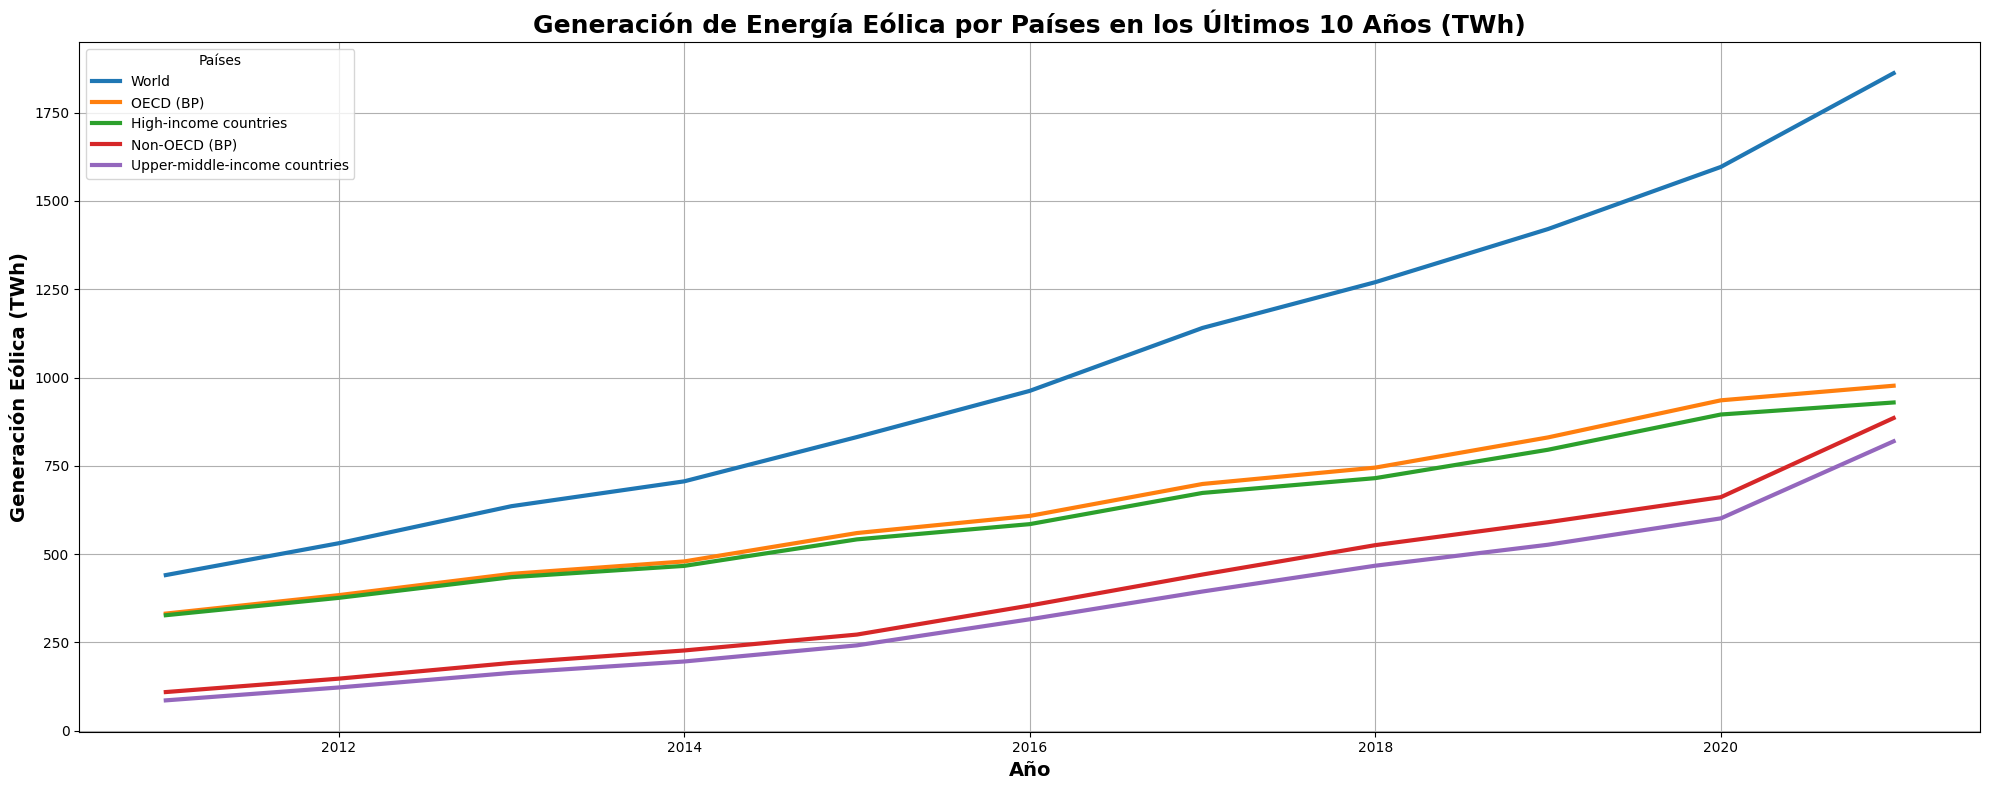

In [161]:
last_10_years_start = 2021 - 10

top_wind_countries = df[df['Year'] == 2021].nlargest(5, 'Wind Generation - TWh')
plt.figure(figsize=(20, 8))

for country in top_wind_countries['Entity']:
    country_data = df[(df['Entity'] == country) & (df['Year'] >= last_10_years_start)]
    plt.plot(country_data['Year'], country_data['Wind Generation - TWh'], linewidth=3, label=country)

plt.title('Generación de Energía Eólica por Países en los Últimos 10 Años (TWh)', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14, fontweight='bold')
plt.ylabel('Generación Eólica (TWh)', fontsize=14, fontweight='bold')
plt.legend(title='Países')
plt.grid(True)
plt.tight_layout()
plt.show()

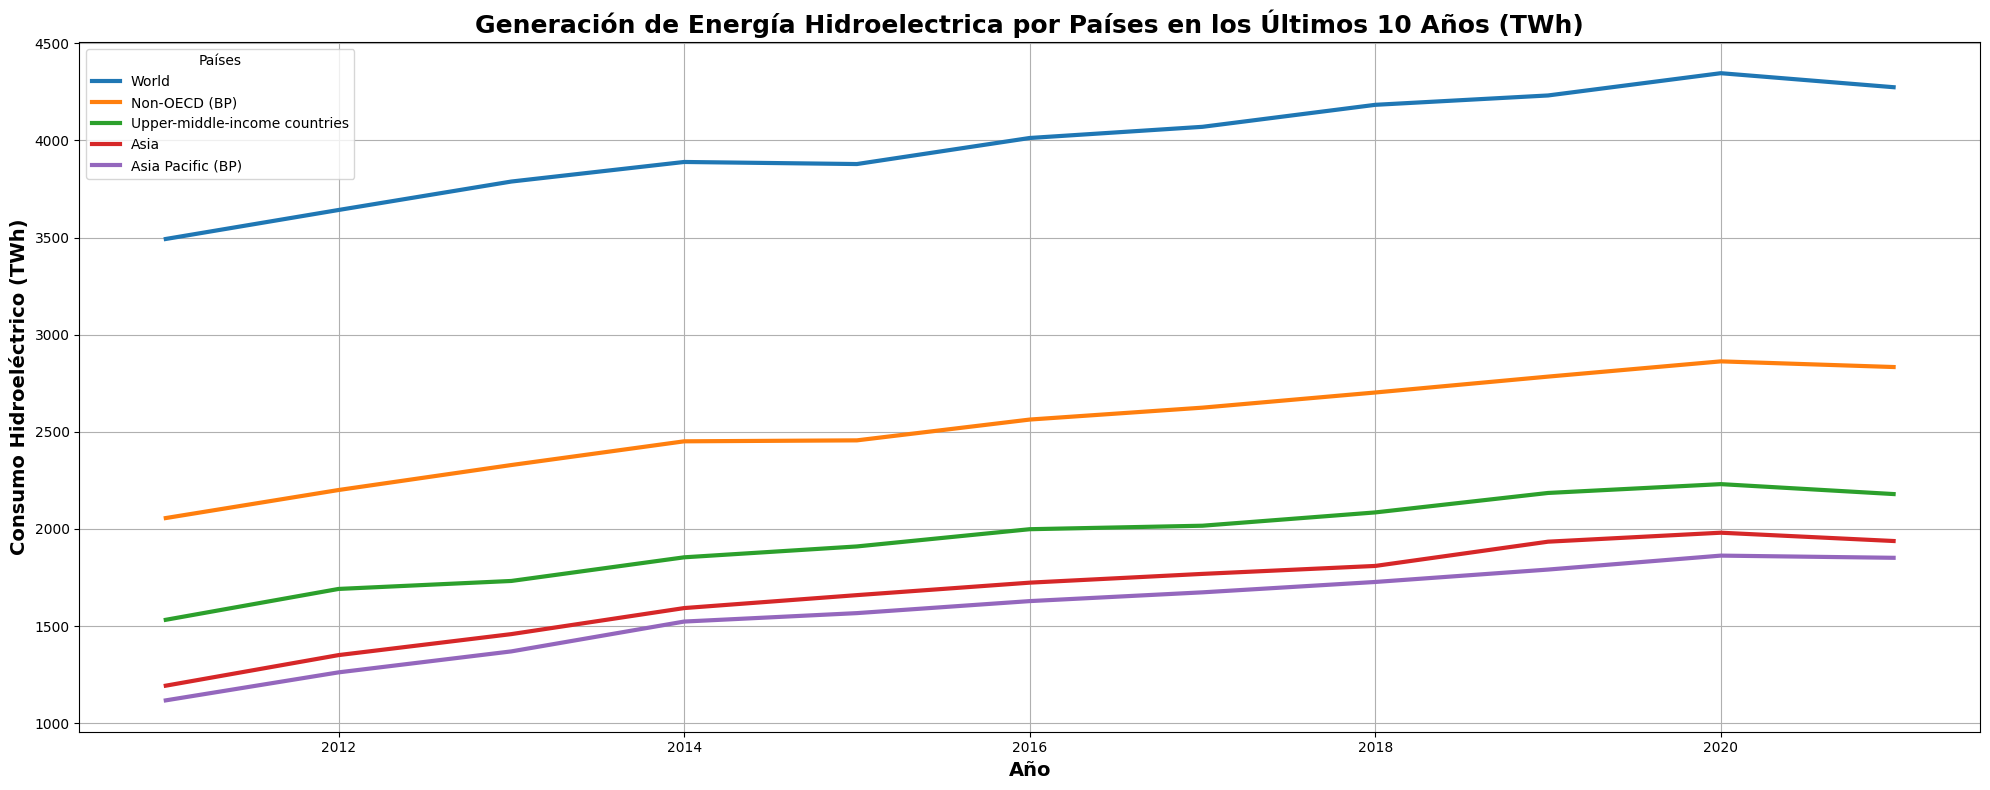

In [162]:
last_10_years_start = 2021 - 10

top_wind_countries = df[df['Year'] == 2021].nlargest(5, 'Hydro Generation - TWh')

plt.figure(figsize=(20, 8))

for country in top_wind_countries['Entity']:
    country_data = df[(df['Entity'] == country) & (df['Year'] >= last_10_years_start)]
    plt.plot(country_data['Year'], country_data['Hydro Generation - TWh'], linewidth = 3, label = country)


plt.title('Generación de Energía Hidroelectrica por Países en los Últimos 10 Años (TWh)', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14, fontweight='bold')
plt.ylabel('Consumo Hidroeléctrico (TWh)', fontsize=14, fontweight='bold')
plt.legend(title='Países')
plt.grid(True)
plt.tight_layout()
plt.show()

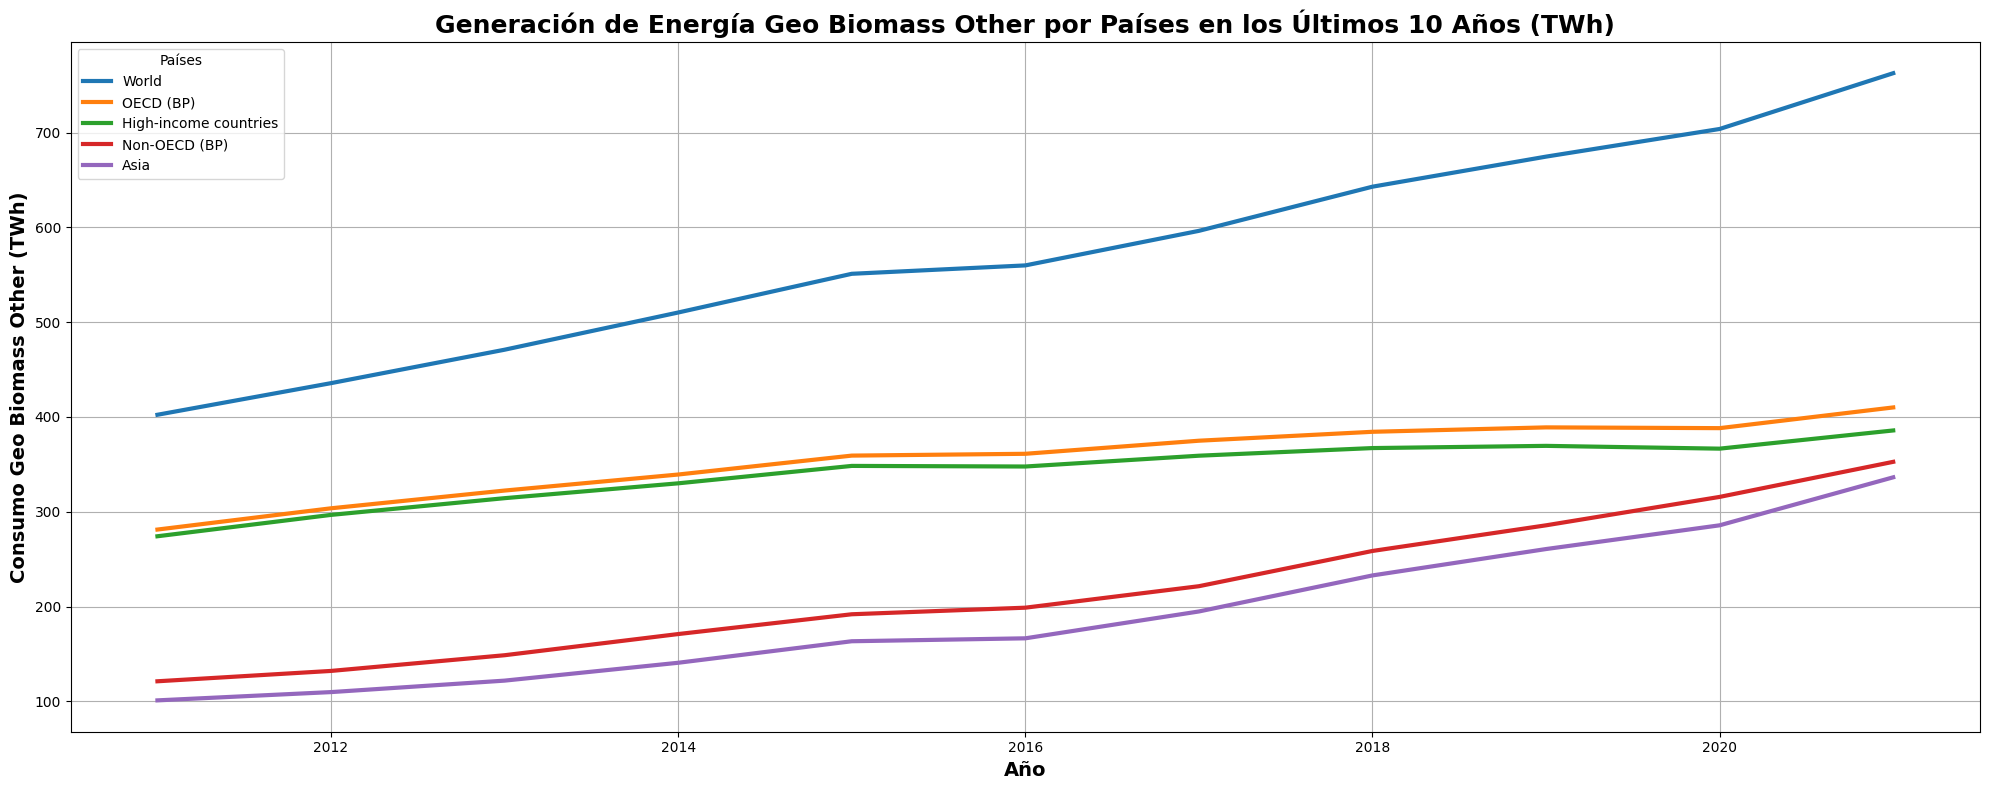

In [163]:
last_10_years_start = 2021 - 10

top_wind_countries = df[df['Year'] == 2021].nlargest(5, 'Geo Biomass Other - TWh')

plt.figure(figsize=(20, 8))

for country in top_wind_countries['Entity']:
    country_data = df[(df['Entity'] == country) & (df['Year'] >= last_10_years_start)]
    plt.plot(country_data['Year'], country_data['Geo Biomass Other - TWh'], linewidth = 3, label = country)


plt.title('Generación de Energía Geo Biomass Other por Países en los Últimos 10 Años (TWh)', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14, fontweight='bold')
plt.ylabel('Consumo Geo Biomass Other (TWh)', fontsize=14, fontweight='bold')
plt.legend(title='Países')
plt.grid(True)
plt.tight_layout()
plt.show()

Ahora se analizará el comportamiento de la variable "Total de energía renovable" a lo largo de los ultimos 50 años.

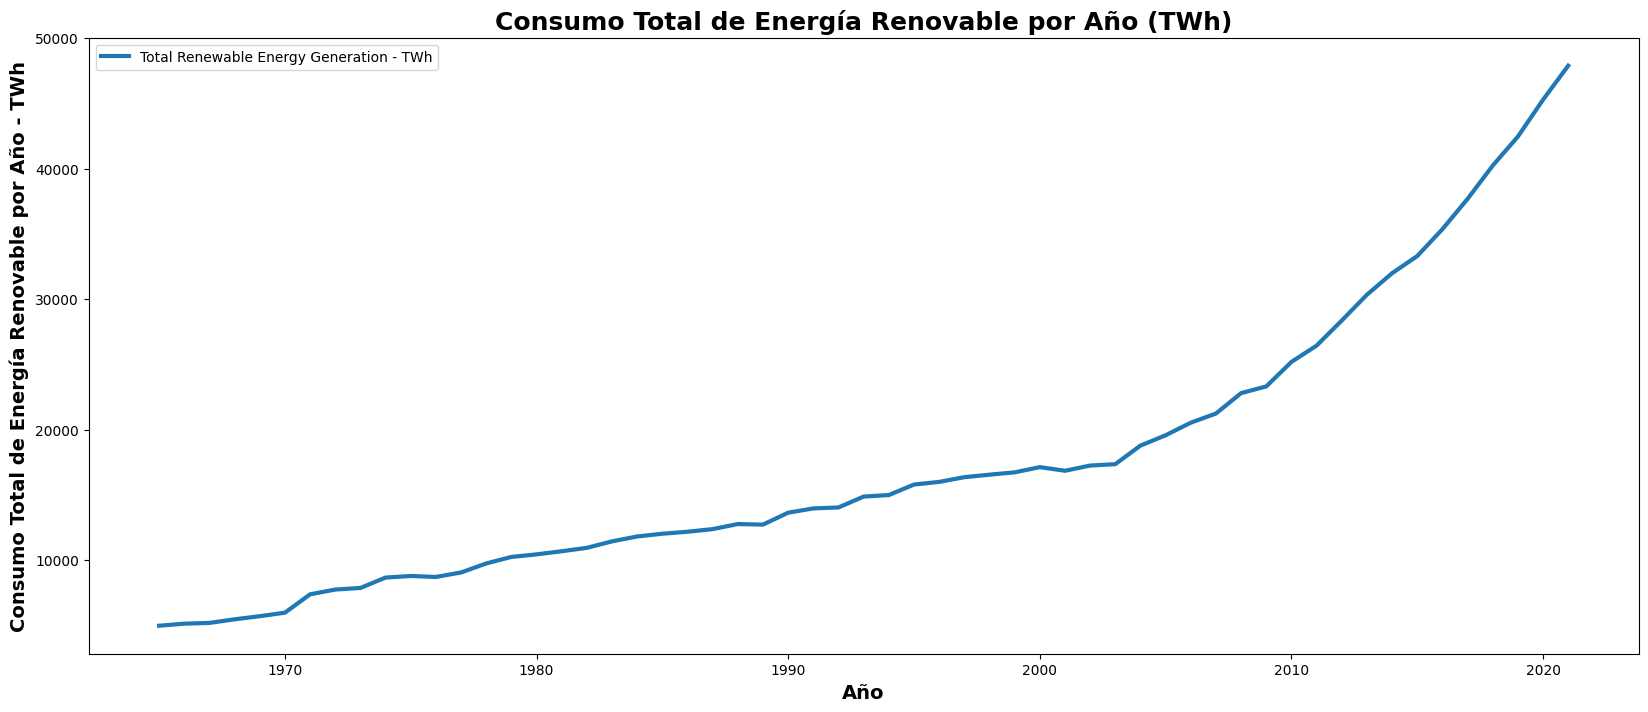

In [164]:
total_energy_by_year = df.groupby('Year').sum(numeric_only=True)

ax = total_energy_by_year.plot(y='Total Renewable Energy Generation - TWh', figsize=(20, 8), linewidth=3, title='Consumo Total de Energía Renovable por Año (TWh)')
ax.set_title('Consumo Total de Energía Renovable por Año (TWh)', fontsize=18, fontweight='bold')
ax.set_xlabel('Año', fontsize=14, fontweight='bold')
ax.set_ylabel('Consumo Total de Energía Renovable por Año - TWh', fontsize=14, fontweight='bold')
plt.show()

Se observará esta variable en EEUU.

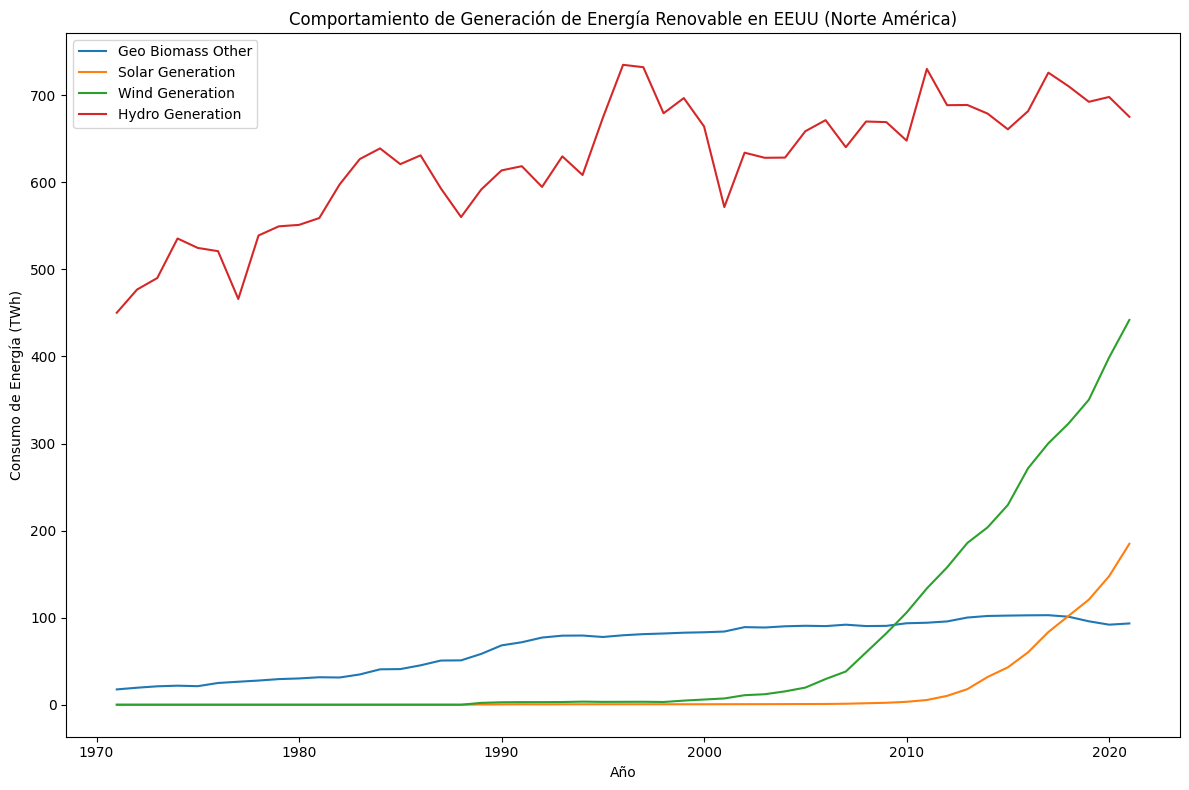

In [165]:
EEUU_data = df[df["Entity"] == 'North America']


plt.figure(figsize=(12, 8))
sns.lineplot(x="Year", y = "Geo Biomass Other - TWh", data = EEUU_data, label = "Geo Biomass Other")
sns.lineplot(x="Year", y = "Solar Generation - TWh", data = EEUU_data, label = "Solar Generation")
sns.lineplot(x="Year", y = "Wind Generation - TWh", data = EEUU_data, label = "Wind Generation")
sns.lineplot(x="Year", y = "Hydro Generation - TWh", data = EEUU_data, label = "Hydro Generation")

plt.title("Comportamiento de Generación de Energía Renovable en EEUU (Norte América)")
plt.xlabel("Año")
plt.ylabel("Consumo de Energía (TWh)")
plt.legend()
plt.tight_layout()
plt.show()

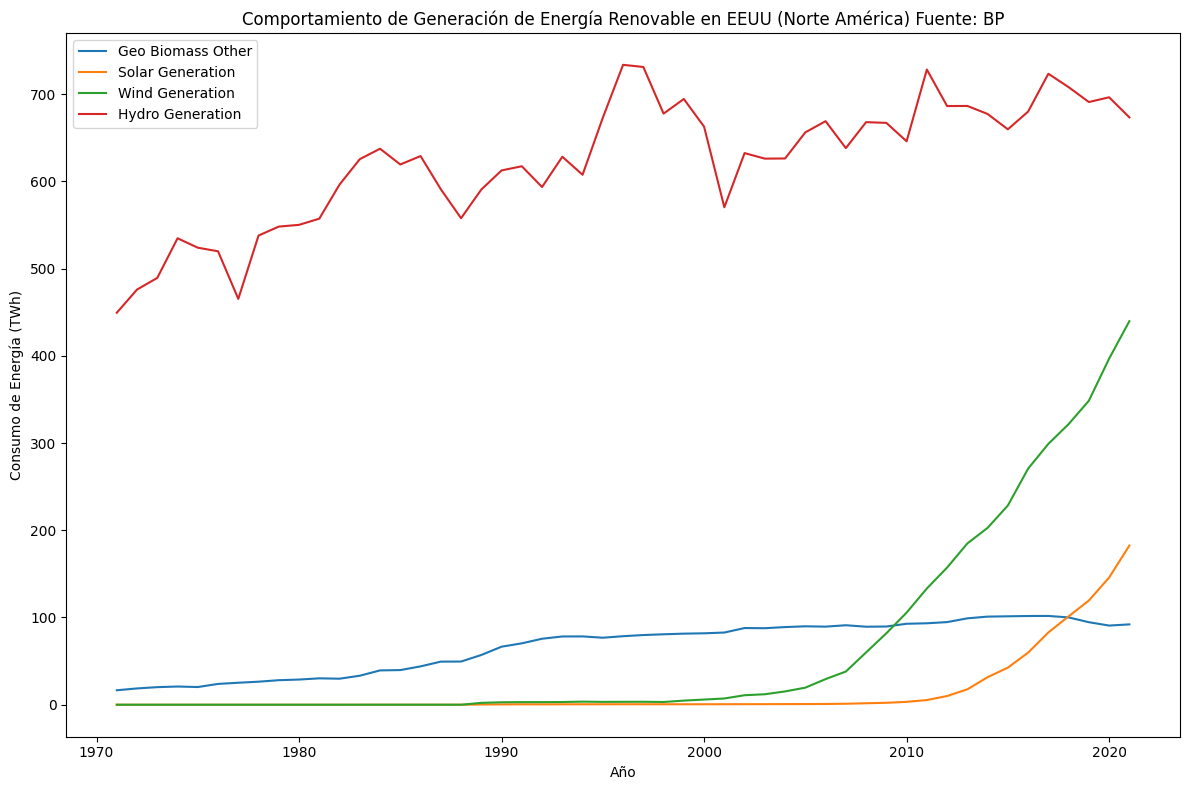

In [166]:
EEUU_data_BP = df[df["Entity"] == 'North America (BP)']
plt.figure(figsize=(12, 8))
sns.lineplot(x="Year", y = "Geo Biomass Other - TWh", data = EEUU_data_BP, label = "Geo Biomass Other")
sns.lineplot(x="Year", y = "Solar Generation - TWh", data = EEUU_data_BP, label = "Solar Generation")
sns.lineplot(x="Year", y = "Wind Generation - TWh", data = EEUU_data_BP, label = "Wind Generation")
sns.lineplot(x="Year", y = "Hydro Generation - TWh", data = EEUU_data_BP, label = "Hydro Generation")

plt.title("Comportamiento de Generación de Energía Renovable en EEUU (Norte América) Fuente: BP")
plt.xlabel("Año")
plt.ylabel("Consumo de Energía (TWh)")
plt.legend()
plt.tight_layout()
plt.show()

Analizaremos el Top 10 de los países u organizaciones con el mayor consumo de energía renovable.

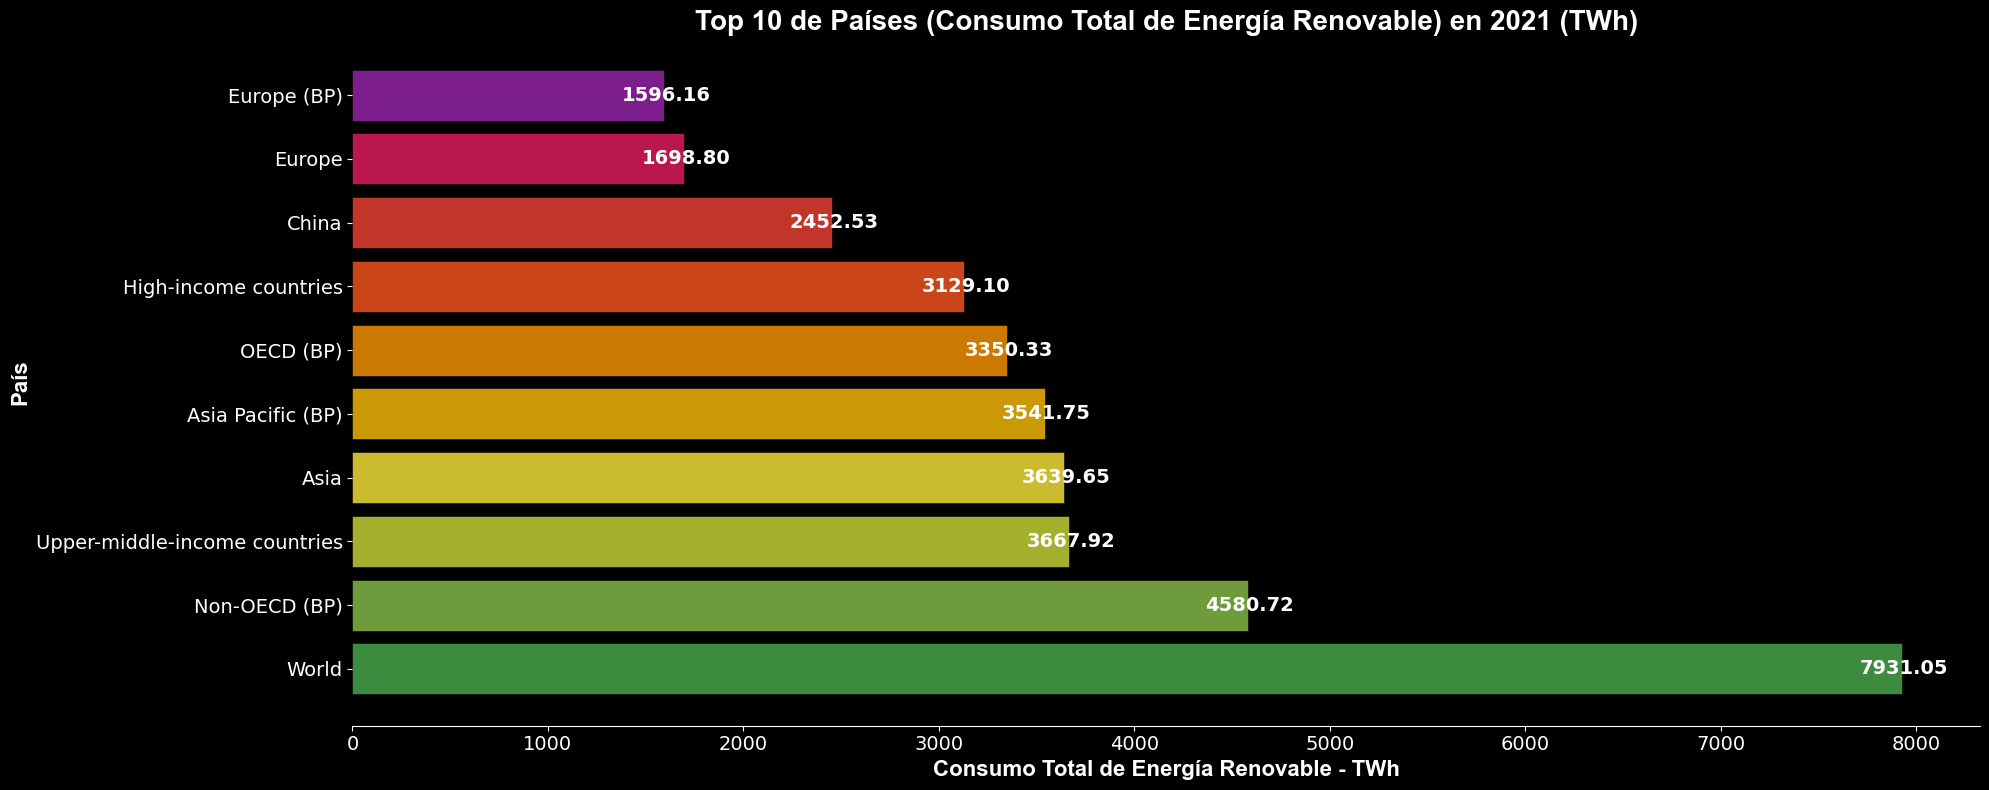

In [167]:

top_total_energy_countries_2021 = df[df['Year'] == 2021].nlargest(10, 'Total Renewable Energy Generation - TWh')

color_list = ['#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800', '#FF5722', '#F44336', '#E91E63', '#9C27B0']

title_font = {'fontname':'Arial', 'size':'20', 'color':'white', 'weight':'bold'}
axis_font = {'fontname':'Arial', 'size':'16', 'color':'white', 'weight':'bold'}

fig, ax = plt.subplots(figsize=(20, 8))
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

bars = ax.barh(top_total_energy_countries_2021['Entity'], 
               top_total_energy_countries_2021['Total Renewable Energy Generation - TWh'], 
               color = color_list, edgecolor = 'black')

for bar in bars:
    bar.set_edgecolor("black")
    bar.set_linewidth(0.5)
    bar.set_alpha(0.8)

for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.2f}', 
                xy=(width + 10, bar.get_y() + bar.get_height() / 2),
                ha='center', va='center',
                color='white', fontsize=14, fontweight='bold')

ax.set_title('Top 10 de Países (Consumo Total de Energía Renovable) en 2021 (TWh)', **title_font)
ax.set_xlabel('Consumo Total de Energía Renovable - TWh', **axis_font)
ax.set_ylabel('País', **axis_font)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')

plt.tight_layout()
plt.show()

Ahora se detallara el comportamiento de la variable relacionada al consumo total de energia renovable en EEUU.

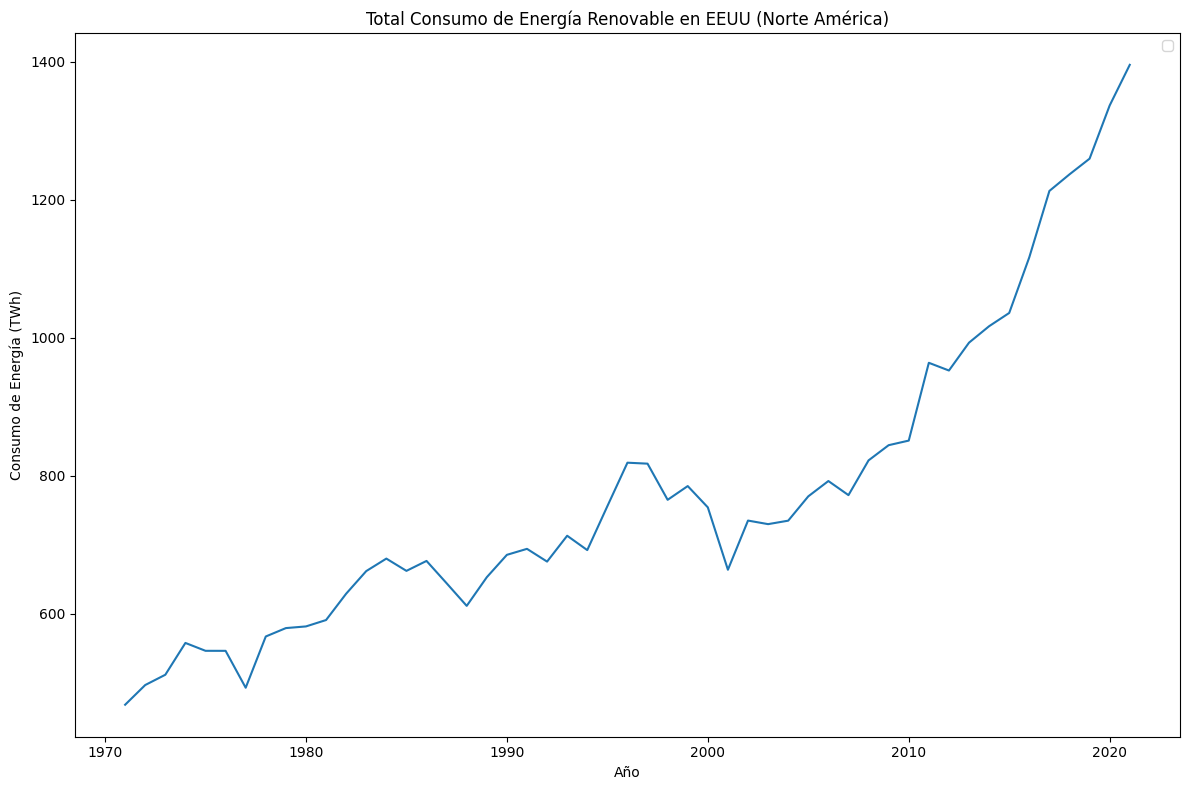

In [168]:
EEUU_data= df[df["Entity"] == 'North America']
plt.figure(figsize=(12, 8))
sns.lineplot(x="Year", y = "Total Renewable Energy Generation - TWh", data = EEUU_data)

plt.title("Total Consumo de Energía Renovable en EEUU (Norte América)")
plt.xlabel("Año")
plt.ylabel("Consumo de Energía (TWh)")
plt.legend()
plt.tight_layout()
plt.show()

Se ha visto una creciente demanda y/o consumo de las energias cuya fuente es de naturaleza renovable. Se verificará su composición, para asi ver cual fuente representa una mayor proporción.

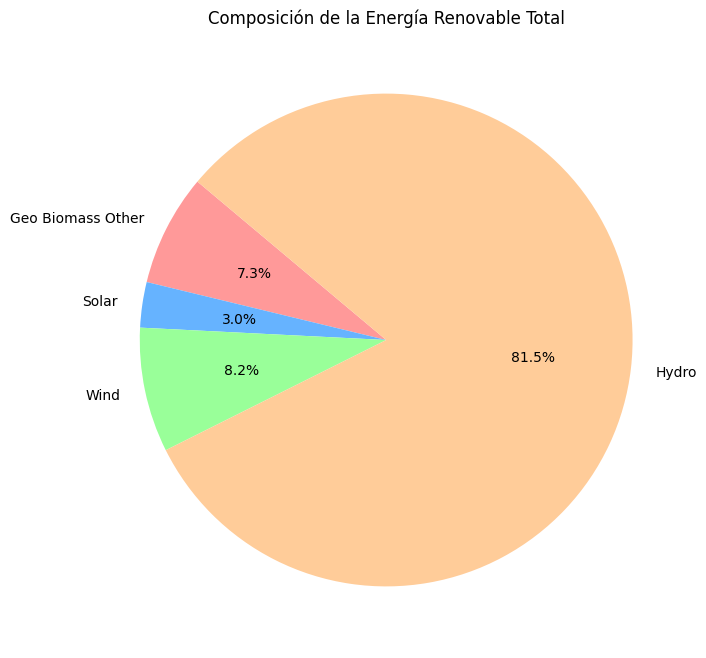

In [169]:

total_geo_biomass = df['Geo Biomass Other - TWh'].sum()
total_solar = df['Solar Generation - TWh'].sum()
total_wind = df['Wind Generation - TWh'].sum()
total_hydro = df['Hydro Generation - TWh'].sum()

renewable_sources = [total_geo_biomass, total_solar, total_wind, total_hydro]
labels = ['Geo Biomass Other', 'Solar', 'Wind', 'Hydro']

plt.figure(figsize=(8, 8))
plt.pie(renewable_sources, labels = labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title("Composición de la Energía Renovable Total")
plt.show()

Se procederá con el análisis de la composicion del consumo de energia renovable por año.

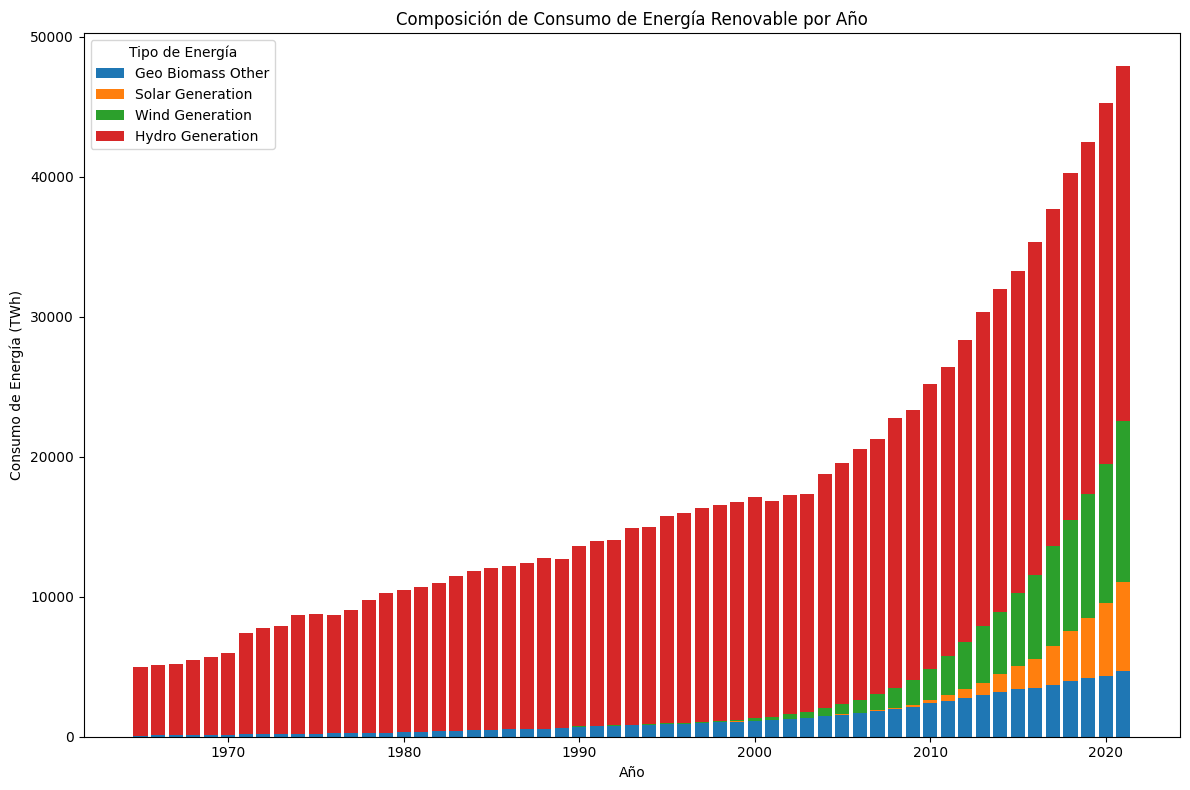

In [170]:
yearly_data = df.groupby('Year')[['Geo Biomass Other - TWh', 
                                  'Solar Generation - TWh', 
                                  'Wind Generation - TWh', 
                                  'Hydro Generation - TWh']].sum()
plt.figure(figsize=(12, 8))

# gráfico de barras apilado
plt.bar(yearly_data.index, yearly_data['Geo Biomass Other - TWh'], label='Geo Biomass Other')
plt.bar(yearly_data.index, yearly_data['Solar Generation - TWh'], 
        bottom=yearly_data['Geo Biomass Other - TWh'], label='Solar Generation')
plt.bar(yearly_data.index, yearly_data['Wind Generation - TWh'], 
        bottom=yearly_data['Geo Biomass Other - TWh'] + yearly_data['Solar Generation - TWh'], label='Wind Generation')
plt.bar(yearly_data.index, yearly_data['Hydro Generation - TWh'], 
        bottom=yearly_data['Geo Biomass Other - TWh'] + yearly_data['Solar Generation - TWh'] + yearly_data['Wind Generation - TWh'], label='Hydro Generation')

# título y etiquetas
plt.title('Composición de Consumo de Energía Renovable por Año')
plt.xlabel('Año')
plt.ylabel('Consumo de Energía (TWh)')
plt.legend(title="Tipo de Energía")
plt.tight_layout()

plt.show()

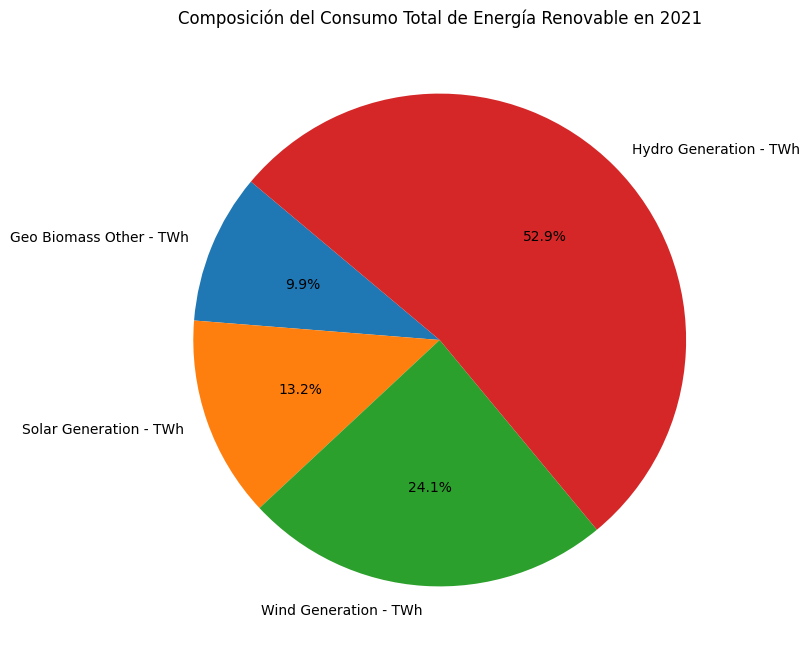

In [171]:
# Filtro
ultimo_anio = df['Year'].max()
datos_ultimo_anio = df[df['Year'] == ultimo_anio]

# funcion de agg
total_renewable = datos_ultimo_anio[['Geo Biomass Other - TWh', 
                                     'Solar Generation - TWh', 
                                     'Wind Generation - TWh', 
                                     'Hydro Generation - TWh']].sum()

# Config
plt.figure(figsize=(8, 8))
plt.pie(total_renewable, labels=total_renewable.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Composición del Consumo Total de Energía Renovable en {ultimo_anio}')
plt.show()

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5426 entries, 0 to 5609
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Entity                                   5426 non-null   object 
 1   Year                                     5426 non-null   int64  
 2   Geo Biomass Other - TWh                  5426 non-null   float64
 3   Solar Generation - TWh                   5426 non-null   float64
 4   Wind Generation - TWh                    5426 non-null   float64
 5   Hydro Generation - TWh                   5426 non-null   float64
 6   Total Renewable Energy Generation - TWh  5426 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 339.1+ KB


In [173]:
df.head(5)

,Entity,Year,Geo Biomass Other - TWh,Solar Generation - TWh,Wind Generation - TWh,Hydro Generation - TWh,Total Renewable Energy Generation - TWh
0,Africa,1971,0.164,0.0,0.0,26.013390,26.177390
1,Africa,1972,0.165,0.0,0.0,29.633196,29.798196
2,Africa,1973,0.170,0.0,0.0,31.345707,31.515707
3,Africa,1974,0.175,0.0,0.0,35.667076,35.842076
4,Africa,1975,0.172,0.0,0.0,37.717968,37.889968


## Proyección en el tiempo  
### EEUU | World : Consumo Total de Energía Renovable
Se procederá a hacer una proyección en el tiempo con el objetivo de pronosticar el comportamiento de la variable "Consumo Total de Energía Renovable" en EEUU y en el mundo (World). Así se obtendrá información oportuna y relevante para la toma de decisiones futuras.

In [174]:
north_america_data = df[df['Entity'] == 'North America']
world_data = df[df['Entity'] == 'World']

# Columna 'Year' a tipo de fecha
north_america_data['Year'] = pd.to_datetime(north_america_data['Year'], format='%Y')
world_data['Year'] = pd.to_datetime(world_data['Year'], format='%Y')

# Preparar los datos para que los reconozca "Prophet"
north_america_df = north_america_data[['Year', 'Total Renewable Energy Generation - TWh']].rename(
    columns={'Year': 'ds', 'Total Renewable Energy Generation - TWh': 'y'})
world_df = world_data[['Year', 'Total Renewable Energy Generation - TWh']].rename(
    columns={'Year': 'ds', 'Total Renewable Energy Generation - TWh': 'y'})

# Se instancia y se ajusta el modelo Prophet para North America
model_na = Prophet(yearly_seasonality=True)
model_na.fit(north_america_df)

# Se hacen los pronósticos para los próximos años (Use 10 años, es decir, hasta 2031)
future_na = model_na.make_future_dataframe(periods=10, freq='Y')  # 10 años hasta 2031
forecast_na = model_na.predict(future_na)

# Ahora Se instancia y se ajusta el modelo Prophet para World
model_world = Prophet(yearly_seasonality=True)
model_world.fit(world_df)

# Se hacen los pronósticos para los próximos años (Use 10 años, es decir, hasta 2031)
future_world = model_world.make_future_dataframe(periods=10, freq='Y')  # 10 años hasta 2031
forecast_world = model_world.predict(future_world)

# Filtr0 los datos para mostrar solo desde 2011 hasta 2031
filtered_north_america = north_america_df[north_america_df['ds'].dt.year >= 2011]
filtered_forecast_na = forecast_na[(forecast_na['ds'].dt.year >= 2011) & (forecast_na['ds'].dt.year <= 2031)]

# Filtr0 los datos para mostrar solo desde 2011 hasta 2031
filtered_world = world_df[world_df['ds'].dt.year >= 2011]
filtered_forecast_world = forecast_world[(forecast_world['ds'].dt.year >= 2011) & (forecast_world['ds'].dt.year <= 2031)]

21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing


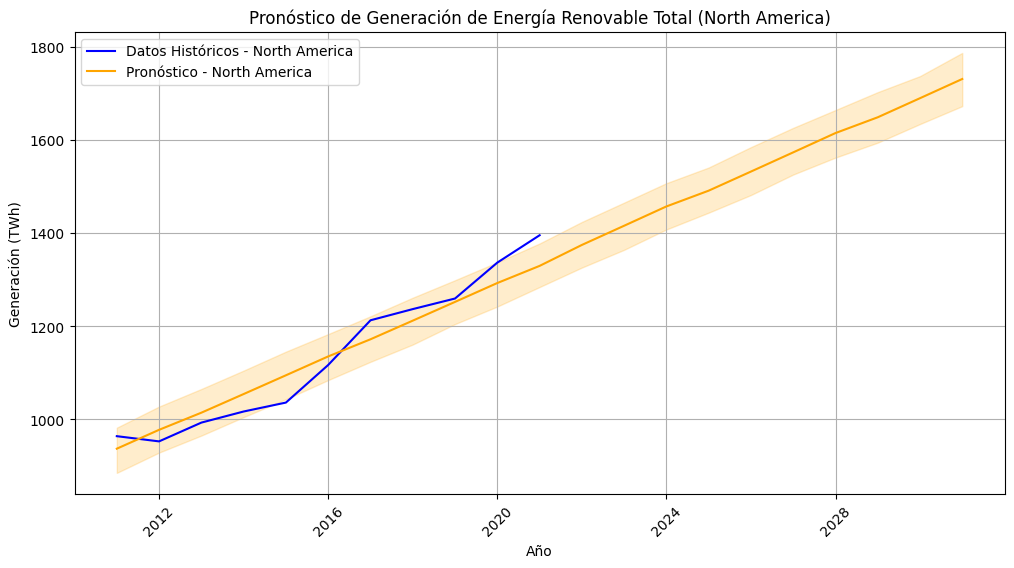

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_north_america['ds'], filtered_north_america['y'], label='Datos Históricos - North America', color='blue')
plt.plot(filtered_forecast_na['ds'], filtered_forecast_na['yhat'], label='Pronóstico - North America', color='orange')
plt.fill_between(filtered_forecast_na['ds'], filtered_forecast_na['yhat_lower'], filtered_forecast_na['yhat_upper'], color='orange', alpha=0.2)
plt.title('Pronóstico de Generación de Energía Renovable Total (North America)')
plt.xlabel('Año')
plt.ylabel('Generación (TWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

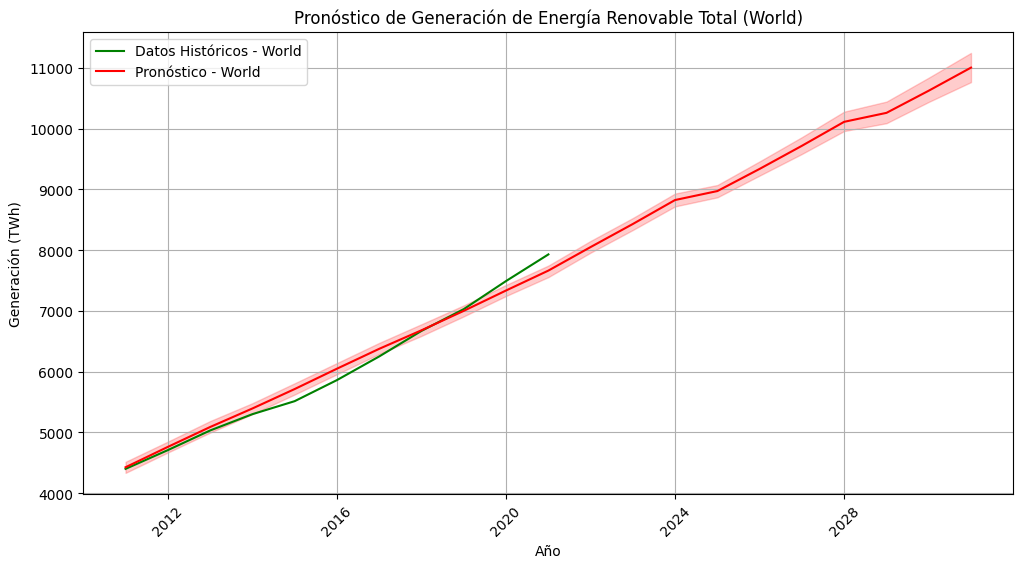

In [176]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_world['ds'], filtered_world['y'], label='Datos Históricos - World', color='green')
plt.plot(filtered_forecast_world['ds'], filtered_forecast_world['yhat'], label='Pronóstico - World', color='red')
plt.fill_between(filtered_forecast_world['ds'], filtered_forecast_world['yhat_lower'], filtered_forecast_world['yhat_upper'], color='red', alpha=0.2)
plt.title('Pronóstico de Generación de Energía Renovable Total (World)')
plt.xlabel('Año')
plt.ylabel('Generación (TWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## CONCLUSIONES:
### Despúes de analizar el dataset se han llegado a estas conclusiones: 
- Las fuentes renovable se han convertido en una fuente de energía con crecimiento exponencial desde la decada de los 70.
- Se puede observar su fortalecimiento y aceptación por parte de consumidores y productores.
- Se evidencia que el consumo de energías renovables ha crecido, lo cual se puede traducir a un crecimiento de la demanda de este tipo de fuentes energéticas.
- Se puede evidenciar una transición gradual hacia energías amigables con el medio ambiente.
### Teniendo en cuenta la proyección efecutada se pueden plantear las siguientes hipotesis:
- Cada vez los consumidores basan su decision de compra en mayor a medida a productos con un ciclo de vida "eco-friendly". Lo que traduce a fuentes de energía renovable como su principal fuente de producción.
- Debido a la idea anteriormente expuesta se puede afirmar que una estrategia potencializadora para toda empresa, en cuanto, a adquisicon y preferencia de clientes, es incoporar políticas de sustentabilidad. Ya que estas medidas se traducen a mejor aceptación, atracción de clientes y por lo tanto, incremento de ventas.
- La tendencia reafirma la tendencia de crecimiento expuesta desde la decada de los 70 del siglo pasado. Esto, acompañado de distintos fenomenos y sitauciones geopoliticas como las ocurridas en Ucrania potencializan esta transición, abandonando el petroleo como fuente de energía y desarrollando cada vez tecnologías que permitan desarrollar y fortalecer la producción de energías renovables.